# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [45]:
from sys import exec_prefix

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [46]:
try:
    df_raw = pd.read_csv('../data/checker_submits.csv')
    print("Read file successfully")
except FileNotFoundError as e:
    print("File not found")
    raise e

# print(df_raw.head())
# print(df.info())


Read file successfully


In [47]:
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

In [48]:
df = pd.DataFrame({
    'uid': df_raw['uid'],
    'labname': df_raw['labname'],
    'numTrials': df_raw['numTrials'],
    'hour': df_raw['timestamp'].dt.hour,
    'dayofweek': df_raw['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
})

print("\nНовый датафрейм:")
print(df.head())
print(f"\nРаспределение по дням недели:")
print(df['dayofweek'].value_counts().sort_index())
print(df.info())



Новый датафрейм:
      uid   labname  numTrials  hour  dayofweek
0  user_4  project1          1     5          4
1  user_4  project1          2     5          4
2  user_4  project1          3     5          4
3  user_4  project1          4     5          4
4  user_4  project1          5     5          4

Распределение по дням недели:
0    136
1    274
2    149
3    396
4    104
5    271
6    356
Name: dayofweek, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        1686 non-null   object
 1   labname    1686 non-null   object
 2   numTrials  1686 non-null   int64 
 3   hour       1686 non-null   int64 
 4   dayofweek  1686 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 66.0+ KB
None


In [49]:
# Определяем категориальные и числовые признаки
categorical_features = ['uid', 'labname']
numerical_features = ['numTrials', 'hour']
target = 'dayofweek'

# Целевая перменная
y = df[target].values

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_features])


feature_names = encoder.get_feature_names(categorical_features)

# Создаем df с закодированными признаками
df_encoded = pd.DataFrame(encoded_features, columns=feature_names)

# Добавляем числовые признаки
for col in numerical_features:
    df_encoded[col] = df[col].values

print(f"\nПосле OneHotEncoder: {df_encoded.shape[1]} признаков")


После OneHotEncoder: 43 признаков


In [50]:
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])


In [51]:
df_encoded['dayofweek'] = y
try:
    df_encoded.to_csv('../data/dayofweek.csv', index=False)
    print("\nДатафрейм сохранен в '../data/dayofweek.csv'")
except FileExistsError as e:
    print("File cannot to be Exisit")
    raise

print(df_encoded.info())


Датафрейм сохранен в '../data/dayofweek.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid_user_0        1686 non-null   float64
 1   uid_user_1        1686 non-null   float64
 2   uid_user_10       1686 non-null   float64
 3   uid_user_11       1686 non-null   float64
 4   uid_user_12       1686 non-null   float64
 5   uid_user_13       1686 non-null   float64
 6   uid_user_14       1686 non-null   float64
 7   uid_user_15       1686 non-null   float64
 8   uid_user_16       1686 non-null   float64
 9   uid_user_17       1686 non-null   float64
 10  uid_user_18       1686 non-null   float64
 11  uid_user_19       1686 non-null   float64
 12  uid_user_2        1686 non-null   float64
 13  uid_user_20       1686 non-null   float64
 14  uid_user_21       1686 non-null   float64
 15  uid_user_22       1686 non-null   float64
 

In [52]:
X = df_encoded.drop('dayofweek', axis=1)
feature_names_all = X.columns.tolist()

In [53]:
most_common_day = pd.Series(y).mode()[0]
naive_predictions = [most_common_day] * len(y)
naive_accuracy = accuracy_score(y, naive_predictions)
print(f"\nНаивный классификатор (всегда предсказывает день {most_common_day}):")
print(f"Точность наивного классификатора: {naive_accuracy}")



Наивный классификатор (всегда предсказывает день 3):
Точность наивного классификатора: 0.23487544483985764


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [54]:
def plot_feature_importance(importances, feature_names, top_n=10, title="Feature Importance"):
    """
    Рисует горизонтальный барплот с топ-N важными признаками

    importances: массив важностей признаков
    feature_names: список названий признаков
    top_n: количество признаков для отображения
    title: заголовок графика
    """
    # Создаем DataFrame для удобства
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': abs(importances)  # Используем абсолютные значения
    })

    # Сортируем и берем топ-N
    top_features = importance_df.nlargest(top_n, 'importance')

    # Создаем график
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance (absolute value)')
    plt.ylabel('Feature')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [55]:
# Обучаем логистическую регрессию
logreg = LogisticRegression(random_state=21, fit_intercept=False, solver='lbfgs')
logreg.fit(X, y)

LogisticRegression(fit_intercept=False, random_state=21)

In [56]:
# Считаем accuracy
logreg_pred = logreg.predict(X)
logreg_accuracy = accuracy_score(y, logreg_pred)
print(f"\nLogistic Regression Accuracy: {logreg_accuracy:.4f}")


Logistic Regression Accuracy: 0.6406


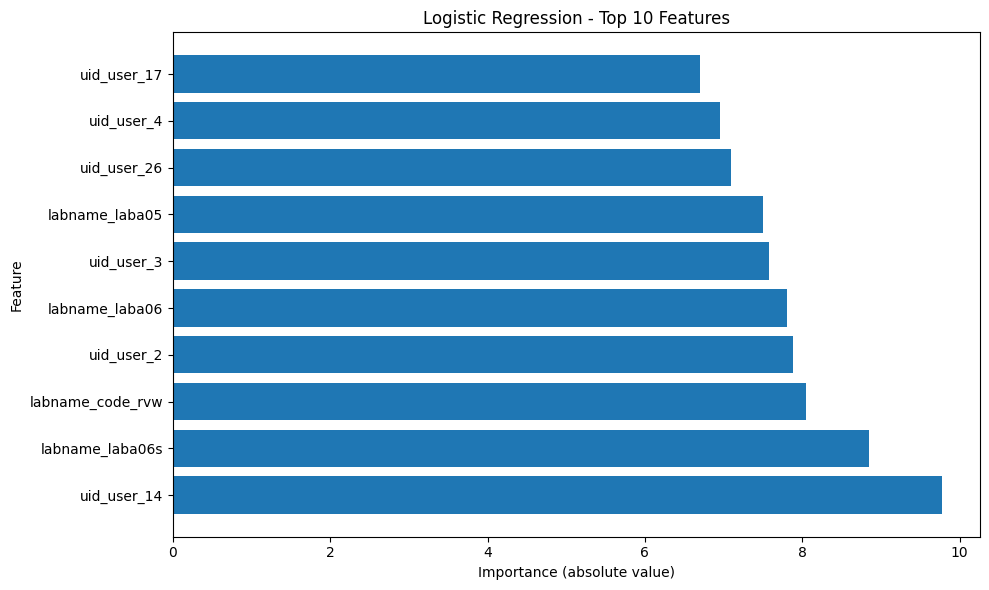

In [57]:
# Визуализация важности признаков
# Для мультиклассовой классификации coef_ имеет форму (n_classes, n_features)
# Суммируем абсолютные значения по всем классам
logreg_importance = abs(logreg.coef_).sum(axis=0)
plot_feature_importance(logreg_importance, feature_names_all, top_n=10,
                       title="Logistic Regression - Top 10 Features")

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [58]:
# 1. Обучаем SVC с линейным ядром через OneVsRestClassifier
svc_linear = OneVsRestClassifier(
    SVC(kernel='linear', probability=True, random_state=21)
)

svc_linear.fit(X, y)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=21))

In [59]:
# 2. Accuracy для разных ядер
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svc_accuracies = {}

print("\nSVC Results:")
for kernel in kernels:
    if kernel == 'linear':
        # Уже обучили выше
        svc_pred = svc_linear.predict(X)
        svc_accuracies[kernel] = accuracy_score(y, svc_pred)
    else:
        # Для остальных ядер используем обычный SVC
        svc = SVC(kernel=kernel, probability=True, random_state=21)
        svc.fit(X, y)
        svc_pred = svc.predict(X)
        svc_accuracies[kernel] = accuracy_score(y, svc_pred)

    print(f"SVC ({kernel}): {svc_accuracies[kernel]:.4f}")


SVC Results:
SVC (linear): 0.6121
SVC (poly): 0.8594
SVC (rbf): 0.8559
SVC (sigmoid): 0.3998


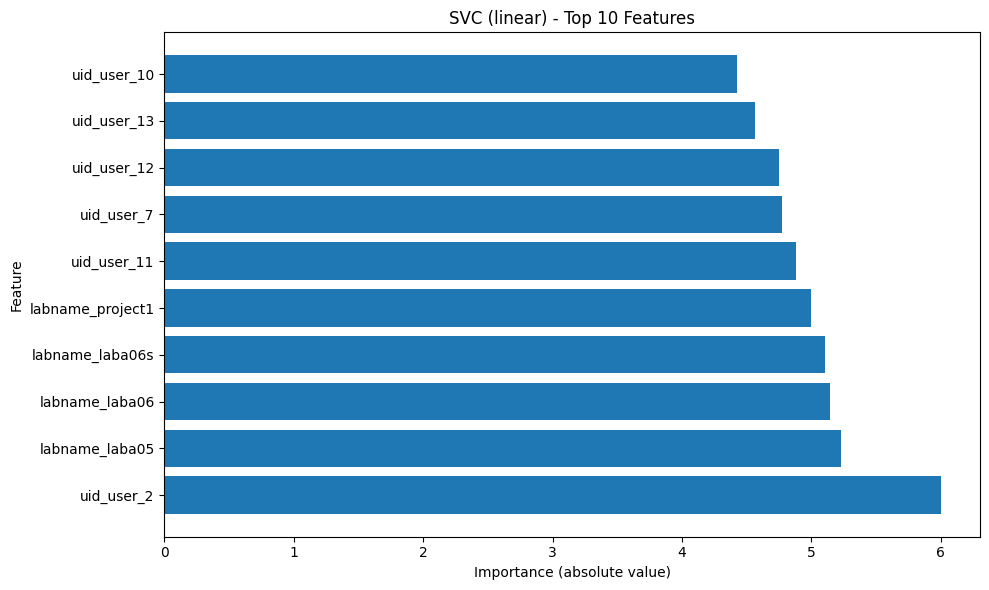

In [60]:
svc_coefs = []
for estimator in svc_linear.estimators_:
    svc_coefs.append(abs(estimator.coef_[0]))

# Суммируем по всем классам
svc_importance = sum(svc_coefs)
plot_feature_importance(svc_importance, feature_names_all, top_n=10,
                       title="SVC (linear) - Top 10 Features")

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [61]:
dt = DecisionTreeClassifier(max_depth=4, random_state=21)
dt.fit(X, y)

dt_pred = dt.predict(X)
dt_accuracy = accuracy_score(y, dt_pred)
print(f"\nDecision Tree (max_depth=4) Accuracy: {dt_accuracy:.4f}")


Decision Tree (max_depth=4) Accuracy: 0.5516


In [62]:
print("\nDecision Tree - разные max_depth:")
dt_accuracies = {}
for depth in [2, 4, 6, 8, 10, 12]:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=21)
    dt_temp.fit(X, y)
    dt_pred_temp = dt_temp.predict(X)
    dt_accuracies[depth] = accuracy_score(y, dt_pred_temp)
    print(f"max_depth={depth}: {dt_accuracies[depth]:.4f}")


Decision Tree - разные max_depth:
max_depth=2: 0.4389
max_depth=4: 0.5516
max_depth=6: 0.6637
max_depth=8: 0.7503
max_depth=10: 0.8197
max_depth=12: 0.8832


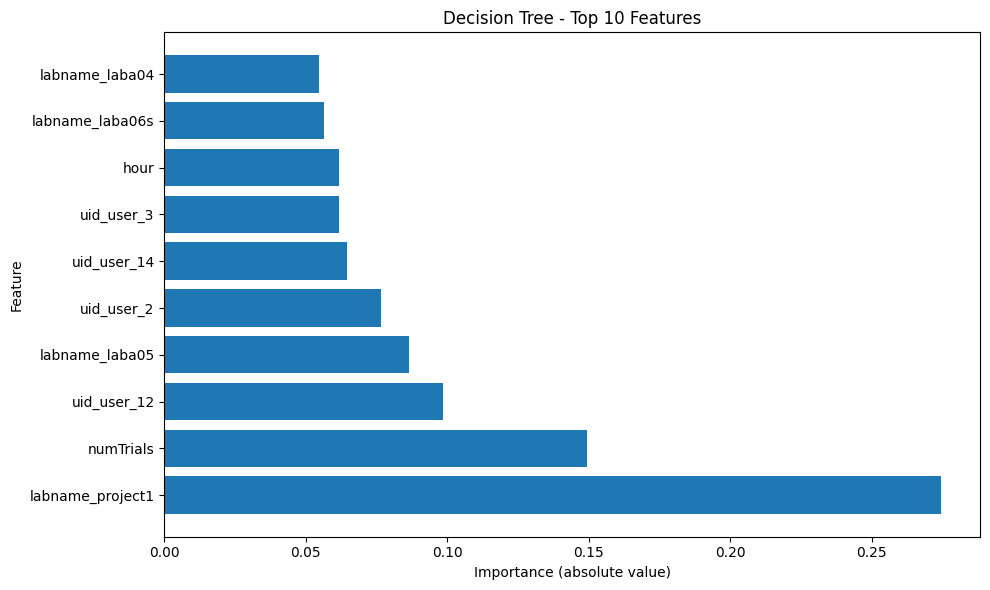

In [63]:
plot_feature_importance(dt.feature_importances_, feature_names_all, top_n=10,
                       title="Decision Tree - Top 10 Features")

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [64]:
rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf.fit(X, y)

RandomForestClassifier(max_depth=25, random_state=21)

In [65]:
rf_pred = rf.predict(X)
rf_accuracy = accuracy_score(y, rf_pred)
print(f"\nRandom Forest (n_estimators=100, max_depth=25) Accuracy: {rf_accuracy:.4f}")


Random Forest (n_estimators=100, max_depth=25) Accuracy: 0.9988



Random Forest - разные параметры:
n_estimators=50, max_depth=10: 0.8796
n_estimators=100, max_depth=10: 0.8701
n_estimators=100, max_depth=25: 0.9988
n_estimators=200, max_depth=25: 1.0000
n_estimators=100, max_depth=None: 1.0000


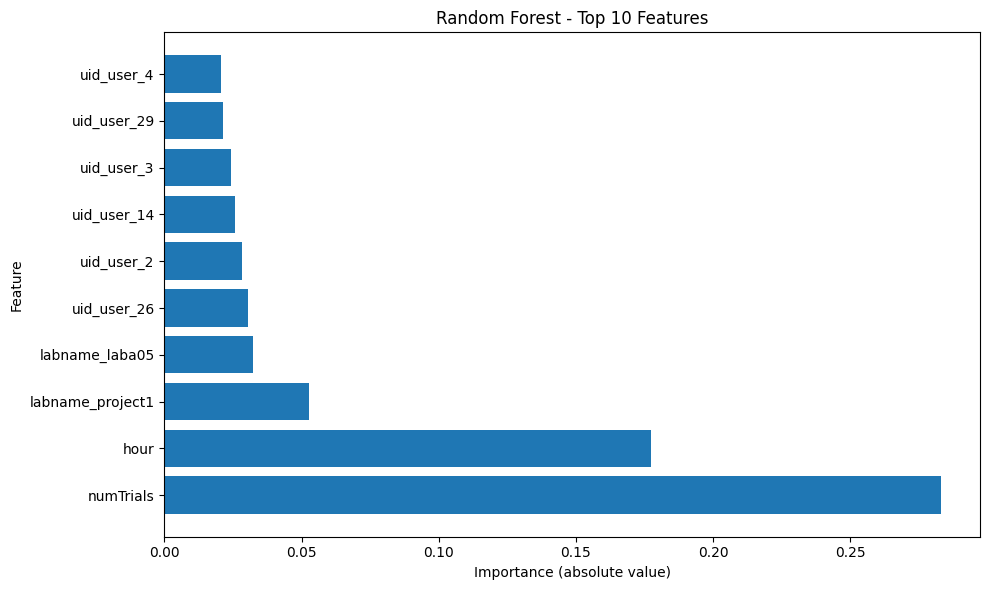

Наивный классификатор: 0.2349
Logistic Regression: 0.6406
SVC (best): 0.8594
Decision Tree (best): 0.8832
Random Forest: 0.9988


In [66]:
print("\nRandom Forest - разные параметры:")
rf_params = [
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 25},
    {'n_estimators': 200, 'max_depth': 25},
    {'n_estimators': 100, 'max_depth': None}
]

for params in rf_params:
    rf_temp = RandomForestClassifier(random_state=21, **params)
    rf_temp.fit(X, y)
    rf_pred_temp = rf_temp.predict(X)
    acc = accuracy_score(y, rf_pred_temp)
    print(f"n_estimators={params['n_estimators']}, max_depth={params['max_depth']}: {acc:.4f}")

# Визуализация важности признаков
plot_feature_importance(rf.feature_importances_, feature_names_all, top_n=10,
                       title="Random Forest - Top 10 Features")

# Итоговое сравнение
print(f"Наивный классификатор: {naive_accuracy:.4f}")
print(f"Logistic Regression: {logreg_accuracy:.4f}")
print(f"SVC (best): {max(svc_accuracies.values()):.4f}")
print(f"Decision Tree (best): {max(dt_accuracies.values()):.4f}")
print(f"Random Forest: {rf_accuracy:.4f}")